In [2]:
!git clone https://github.com/jalpv1//wiki-art-selected-resized-downsampled
!rm -rf .//wiki-art-selected-resized-downsampled/.git
!pip install torchmetrics
!pip install pytorch_lightning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import time
import os
import copy
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
from torchvision.datasets import ImageFolder
import numpy as np
import matplotlib.pyplot as plt
import cv2
import numpy as np
import imageio as io
from PIL import Image
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
!python --version
!nvcc --version
!pip install nvcc4jupyter
%load_ext nvcc4jupyter
class_names = ['Abstract_Expressionism','Baroque','Cubism', 'Fauvism', 'Impressionism','Minimalism','Naive_Art_Primitivism','Pointillism','Rococo','Ukiyo_e']
device = 'cuda'
!pip install torchsampler
class ArtStyleDataset(Dataset):
  def __init__(self, root_dir, transform = None, transform_tensor = None):
     self.imgs = ImageFolder(root_dir)
     self.root_dir = root_dir
     self.transform = transform
     self.transform_tensor = transform_tensor


  def __len__(self):
        return len(self.imgs)

  def __getitem__(self, idx):
        sample, label = self.imgs[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample, label

transform = transforms.Compose([
    transforms.Resize((229, 229)),
    transforms.ToTensor(),
])
#load data
data = ArtStyleDataset('wiki-art-selected-resized-downsampled', transform)

from torch.utils.data import Dataset, DataLoader, random_split
train_size = int(0.8 * len(data))
test_size = int(0.2 * len(data))
#val_size = len(data) - train_size - test_size
train_dataset, test_dataset = random_split(data, [train_size, test_size])

train_loader = DataLoader(train_dataset, shuffle=True,num_workers=4)
test_loader = DataLoader(test_dataset, shuffle=False, num_workers=4)
#val_loader = DataLoader(val_dataset, shuffle=False, num_workers=4)

from torch.utils.data import WeightedRandomSampler

def extract_labels():
  features = []
  labels_ = []
  map_img_feature = {}
  for inputs, labels in train_loader:
      labels_.append(labels.numpy())
  return labels_
y = extract_labels()
y = np.concatenate(y)
unique, counts = np.unique(y, return_counts=True)


#Up sampling
class_weights = [1.0/c for c in counts]
sample_weights = [class_weights[i] for i in y]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights))

train_loader = DataLoader(train_dataset,sampler=sampler, batch_size = 32)
dataset_sizes= {"train" : len(train_loader), "test" : len(test_loader)}

Cloning into 'wiki-art-selected-resized-downsampled'...
remote: Enumerating objects: 18446, done.
remote: Total 18446 (delta 0), reused 0 (delta 0), pack-reused 18446 (from 1)
Receiving objects: 100% (18446/18446), 843.56 MiB | 42.42 MiB/s, done.
Resolving deltas: 100% (4/4), done.
Updating files: 100% (18505/18505), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 960.9/960.9 kB 40.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 105.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 852.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
!rm -rf .//wiki-art-selected-resized-downsampled/.git


In [ ]:
!pip install seaborn

In [2]:
def evaluate_model(predicted, true):
  from sklearn.metrics import classification_report
  import pandas as pd
  from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
  import matplotlib.pyplot as plt
  report_dict = classification_report(predicted, true, target_names=class_names, output_dict=True)
  metrics_df2 = pd.DataFrame(report_dict).transpose()
  print(metrics_df2)
  print("-----------------------------------------------------------------------------------------------------------")
  cm =confusion_matrix(true, predicted, normalize = 'true')
  disp = ConfusionMatrixDisplay(cm*100, display_labels=class_names)
  fig, ax = plt.subplots(figsize=(8, 6))
  disp.plot(cmap="cividis", ax=ax)
  for _, spine in ax.spines.items():
        spine.set_visible(False)
  plt.xticks(rotation=90, ha="right")
  plt.yticks(rotation=0)
  plt.grid(False)
  plt.title("Confusion Matrix")
    #plt.colorbar(ax.collections[0], ax=ax)
  disp = ConfusionMatrixDisplay(confusion_matrix(true, predicted), display_labels=class_names)

  fig, ax = plt.subplots(figsize=(8, 6))
  disp.plot(cmap="cividis", ax=ax)
  for _, spine in ax.spines.items():
        spine.set_visible(False)

  plt.xticks(rotation=90, ha="right")
  plt.yticks(rotation=0)
  plt.grid(False)
  plt.title("Not normalized Confusion Matrix")
  plt.show()


  # Move model to the appropriate device (CPU or GPU)

def validate_model(model, data_loader):
    pred = []
    true = []
    model.eval()

    start_time = time.time()
    total = 0
    correct = 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs.float())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            true.extend(labels.cpu().numpy())
            pred.extend(predicted.cpu().numpy())

        accuracy = 100 * correct / total  # Calculate accuracy based on predictions

        print('Finished Testing')
        print(f'Testing accuracy: {accuracy:.1f} %')

    evaluate_model(pred, true)

In [3]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
import torchmetrics
from torchvision import models

# Initialize metrics storage lists
f1_efficientnet = []
accuracy_efficientnet = []
recall_efficientnet = []
precision_efficientnet = []

class EfficientNetV2S(pl.LightningModule):
    def __init__(self, num_classes):
        super(EfficientNetV2S, self).__init__()
        # Load pretrained EfficientNetV2-S
        self.model = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.DEFAULT)
        self.validation_step_outputs = []
        self.train_step_outputs = []

        # Freeze feature extractor
        for param in self.model.features.parameters():
            param.requires_grad = False

        # Replace classifier
        in_features = self.model.classifier[1].in_features
        self.model.classifier = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes),
            nn.LogSoftmax(dim=1)
        )

        # Metrics
        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes, average='weighted')
        self.val_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes, average='weighted')
        self.f1_val = torchmetrics.F1Score(task="multiclass", num_classes=num_classes, average='weighted')
        self.f1_train = torchmetrics.F1Score(task="multiclass", num_classes=num_classes, average='weighted')
        self.precision_val = torchmetrics.Precision(task="multiclass", num_classes=num_classes, average='weighted')
        self.recall_val = torchmetrics.Recall(task="multiclass", num_classes=num_classes, average='weighted')

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = nn.CrossEntropyLoss()(logits, y)
        preds = torch.argmax(logits, dim=1)

        self.accuracy.update(preds, y)
        self.f1_train.update(preds, y)

        self.train_step_outputs.append(loss)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        val_loss = nn.CrossEntropyLoss()(logits, y)
        preds = torch.argmax(logits, dim=1)

        self.val_accuracy.update(preds, y)
        self.f1_val.update(preds, y)
        self.precision_val.update(preds, y)
        self.recall_val.update(preds, y)

        self.validation_step_outputs.append(val_loss)

    def on_train_epoch_end(self):
        train_acc = self.accuracy.compute()
        epoch_f1_train = self.f1_train.compute()
        print(f"Epoch {self.current_epoch}: Train Accuracy: {train_acc:.4f} F1: {epoch_f1_train:.4f}")
        self.accuracy.reset()
        self.f1_train.reset()

    def on_validation_epoch_end(self):
        epoch_val_acc = self.val_accuracy.compute()
        avg_val_loss = torch.stack(self.validation_step_outputs).mean()
        epoch_f1_val = self.f1_val.compute()
        epoch_precision_val = self.precision_val.compute()
        epoch_recall_val = self.recall_val.compute()

        print(f"Epoch {self.current_epoch}: Validation Accuracy: {epoch_val_acc:.4f} F1: {epoch_f1_val:.4f}  Recall: {epoch_recall_val:.4f}  Precision: {epoch_precision_val:.4f}")
        self.log("validation_epoch_accuracy", epoch_val_acc)
        self.log("validation_epoch_loss", avg_val_loss)
        self.log("f1_val", epoch_f1_val)

        f1_efficientnet.append(epoch_f1_val.cpu().numpy())
        accuracy_efficientnet.append(epoch_val_acc.cpu().numpy())
        recall_efficientnet.append(epoch_recall_val.cpu().numpy())
        precision_efficientnet.append(epoch_precision_val.cpu().numpy())

        self.val_accuracy.reset()
        self.f1_val.reset()
        self.precision_val.reset()
        self.recall_val.reset()
        self.validation_step_outputs.clear()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.classifier.parameters(), lr=0.0001)
        return optimizer


In [4]:
checkpoint_callbackS = ModelCheckpoint(

     monitor='f1_val',
       mode='max',
     dirpath='my/path/',
     filename='efficiennetv2S-{epoch:02d}-{f1_val:.2f}'
)

trainerS = pl.trainer.Trainer(
    max_epochs=15,
   accelerator="cuda",
    callbacks =checkpoint_callbackS,
)

modelResS = EfficientNetV2S(num_classes=num_classes)

trainerS.fit(modelResS, train_loader, test_loader, ckpt_path=None)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


NameError: name 'num_classes' is not defined

In [5]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
import torchmetrics
from torchvision import models

f1_efficientnet = []
accuracy_efficientnet = []
recall_efficientnet = []
precision_efficientnet = []

class Efficientnet_b1(pl.LightningModule):
    def __init__(self, num_classes):
        super(Efficientnet_b1, self).__init__()
        self.model = models.efficientnet_b1(weights=models.EfficientNet_B1_Weights.DEFAULT)
        self.validation_step_outputs = []
        self.train_step_outputs = []

        for param in self.model.features.parameters():
            param.requires_grad = False

        in_features = self.model.classifier[1].in_features
        self.model.classifier = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes),
            nn.LogSoftmax(dim=1)
        )

        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes, average='weighted')
        self.val_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes, average='weighted')
        self.f1_val = torchmetrics.F1Score(task="multiclass", num_classes=num_classes, average='weighted')
        self.f1_train = torchmetrics.F1Score(task="multiclass", num_classes=num_classes, average='weighted')
        self.precision_val = torchmetrics.Precision(task="multiclass", num_classes=num_classes, average='weighted')
        self.recall_val = torchmetrics.Recall(task="multiclass", num_classes=num_classes, average='weighted')

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = nn.CrossEntropyLoss()(logits, y)
        preds = torch.argmax(logits, dim=1)

        self.accuracy.update(preds, y)
        self.f1_train.update(preds, y)

        self.train_step_outputs.append(loss)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        val_loss = nn.CrossEntropyLoss()(logits, y)
        preds = torch.argmax(logits, dim=1)

        self.val_accuracy.update(preds, y)
        self.f1_val.update(preds, y)
        self.precision_val.update(preds, y)
        self.recall_val.update(preds, y)

        self.validation_step_outputs.append(val_loss)

    def on_train_epoch_end(self):
        train_acc = self.accuracy.compute()
        epoch_f1_train = self.f1_train.compute()
        print(f"Epoch {self.current_epoch}: Train Accuracy: {train_acc:.4f} F1: {epoch_f1_train:.4f}")
        self.accuracy.reset()
        self.f1_train.reset()

    def on_validation_epoch_end(self):
        epoch_val_acc = self.val_accuracy.compute()
        avg_val_loss = torch.stack(self.validation_step_outputs).mean()
        epoch_f1_val = self.f1_val.compute()
        epoch_precision_val = self.precision_val.compute()
        epoch_recall_val = self.recall_val.compute()

        print(f"Epoch {self.current_epoch}: Validation Accuracy: {epoch_val_acc:.4f} F1: {epoch_f1_val:.4f}  Recall: {epoch_recall_val:.4f}  Precision: {epoch_precision_val:.4f}")
        self.log("validation_epoch_accuracy", epoch_val_acc)
        self.log("validation_epoch_loss", avg_val_loss)
        self.log("f1_val", epoch_f1_val)

        f1_efficientnet.append(epoch_f1_val.cpu().numpy())
        accuracy_efficientnet.append(epoch_val_acc.cpu().numpy())
        recall_efficientnet.append(epoch_recall_val.cpu().numpy())
        precision_efficientnet.append(epoch_precision_val.cpu().numpy())

        self.val_accuracy.reset()
        self.f1_val.reset()
        self.precision_val.reset()
        self.recall_val.reset()
        self.validation_step_outputs.clear()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.classifier.parameters(), lr=0.0001)
        return optimizer


In [6]:
checkpoint_callbackS = ModelCheckpoint(

     monitor='f1_val',
       mode='max',
     dirpath='my/path2/',
     filename='efficiennetb1_2-{epoch:02d}-{f1_val:.2f}'
)

trainerS = pl.trainer.Trainer(
    max_epochs=25,
   accelerator="cuda",
    callbacks =checkpoint_callbackS,
)

modelResS = Efficientnet_b1(num_classes=10)

trainerS.fit(modelResS, train_loader, test_loader, ckpt_path=None)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
Downloading: "https://download.pytorch.org/models/efficientnet_b1-c27df63c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b1-c27df63c.pth
100%|██████████| 30.1M/30.1M [00:00<00:00, 79.2MB/s]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type                | Params | Mode 
--------------------------------------------------------------
0 | model         | EfficientNet        | 6.8 M  | train
1 | accuracy      | MulticlassAccuracy  | 0      | train
2 | val_accuracy  | MulticlassAccuracy  | 0      | train
3 | f1_val        | MulticlassF1Score   | 0      | train
4 | f1_train      | MulticlassF1Score   | 0      | train
5 | precision_val |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Epoch 0: Validation Accuracy: 0.0000 F1: 0.0000  Recall: 0.0000  Precision: 0.0000


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0: Validation Accuracy: 0.5661 F1: 0.5232  Recall: 0.5661  Precision: 0.5510
Epoch 0: Train Accuracy: 0.4835 F1: 0.4583


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1: Validation Accuracy: 0.6379 F1: 0.6111  Recall: 0.6379  Precision: 0.6537
Epoch 1: Train Accuracy: 0.6079 F1: 0.5789


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2: Validation Accuracy: 0.6760 F1: 0.6607  Recall: 0.6760  Precision: 0.6857
Epoch 2: Train Accuracy: 0.6498 F1: 0.6307


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3: Validation Accuracy: 0.6960 F1: 0.6853  Recall: 0.6960  Precision: 0.7039
Epoch 3: Train Accuracy: 0.6803 F1: 0.6685


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4: Validation Accuracy: 0.7112 F1: 0.7033  Recall: 0.7112  Precision: 0.7144
Epoch 4: Train Accuracy: 0.6963 F1: 0.6880


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5: Validation Accuracy: 0.7244 F1: 0.7185  Recall: 0.7244  Precision: 0.7263
Epoch 5: Train Accuracy: 0.7117 F1: 0.7063


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6: Validation Accuracy: 0.7312 F1: 0.7259  Recall: 0.7312  Precision: 0.7334
Epoch 6: Train Accuracy: 0.7224 F1: 0.7171


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7: Validation Accuracy: 0.7347 F1: 0.7309  Recall: 0.7347  Precision: 0.7381
Epoch 7: Train Accuracy: 0.7287 F1: 0.7249


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8: Validation Accuracy: 0.7428 F1: 0.7392  Recall: 0.7428  Precision: 0.7450
Epoch 8: Train Accuracy: 0.7342 F1: 0.7307


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9: Validation Accuracy: 0.7439 F1: 0.7402  Recall: 0.7439  Precision: 0.7454
Epoch 9: Train Accuracy: 0.7410 F1: 0.7383


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10: Validation Accuracy: 0.7468 F1: 0.7436  Recall: 0.7468  Precision: 0.7470
Epoch 10: Train Accuracy: 0.7534 F1: 0.7506


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11: Validation Accuracy: 0.7501 F1: 0.7472  Recall: 0.7501  Precision: 0.7511
Epoch 11: Train Accuracy: 0.7569 F1: 0.7544


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12: Validation Accuracy: 0.7568 F1: 0.7546  Recall: 0.7568  Precision: 0.7585
Epoch 12: Train Accuracy: 0.7559 F1: 0.7533


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13: Validation Accuracy: 0.7590 F1: 0.7567  Recall: 0.7590  Precision: 0.7608
Epoch 13: Train Accuracy: 0.7672 F1: 0.7648


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14: Validation Accuracy: 0.7593 F1: 0.7570  Recall: 0.7593  Precision: 0.7597
Epoch 14: Train Accuracy: 0.7671 F1: 0.7653


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15: Validation Accuracy: 0.7595 F1: 0.7575  Recall: 0.7595  Precision: 0.7613
Epoch 15: Train Accuracy: 0.7673 F1: 0.7656


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16: Validation Accuracy: 0.7638 F1: 0.7617  Recall: 0.7638  Precision: 0.7657
Epoch 16: Train Accuracy: 0.7764 F1: 0.7749


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17: Validation Accuracy: 0.7598 F1: 0.7581  Recall: 0.7598  Precision: 0.7611
Epoch 17: Train Accuracy: 0.7782 F1: 0.7767


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18: Validation Accuracy: 0.7655 F1: 0.7634  Recall: 0.7655  Precision: 0.7668
Epoch 18: Train Accuracy: 0.7807 F1: 0.7792


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19: Validation Accuracy: 0.7641 F1: 0.7623  Recall: 0.7641  Precision: 0.7662
Epoch 19: Train Accuracy: 0.7795 F1: 0.7779


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20: Validation Accuracy: 0.7593 F1: 0.7563  Recall: 0.7593  Precision: 0.7595
Epoch 20: Train Accuracy: 0.7892 F1: 0.7877


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21: Validation Accuracy: 0.7657 F1: 0.7642  Recall: 0.7657  Precision: 0.7666
Epoch 21: Train Accuracy: 0.7900 F1: 0.7884


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22: Validation Accuracy: 0.7601 F1: 0.7579  Recall: 0.7601  Precision: 0.7626
Epoch 22: Train Accuracy: 0.7986 F1: 0.7968


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23: Validation Accuracy: 0.7644 F1: 0.7617  Recall: 0.7644  Precision: 0.7642
Epoch 23: Train Accuracy: 0.7878 F1: 0.7865


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24: Validation Accuracy: 0.7698 F1: 0.7681  Recall: 0.7698  Precision: 0.7710
Epoch 24: Train Accuracy: 0.7971 F1: 0.7955


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=25` reached.


Finished Testing
Testing accuracy: 73.5 %
                        precision    recall  f1-score      support
Abstract_Expressionism   0.720430  0.733577  0.726944   274.000000
Baroque                  0.762963  0.693603  0.726631   297.000000
Cubism                   0.780702  0.757447  0.768898   235.000000
Fauvism                  0.356322  0.508197  0.418919    61.000000
Impressionism            0.853659  0.749235  0.798046   327.000000
Minimalism               0.858407  0.815126  0.836207   119.000000
Naive_Art_Primitivism    0.654167  0.720183  0.685590   218.000000
Pointillism              0.587302  0.740000  0.654867    50.000000
Rococo                   0.649718  0.688623  0.668605   167.000000
Ukiyo_e                  0.869159  0.902913  0.885714   103.000000
accuracy                 0.734738  0.734738  0.734738     0.734738
macro avg                0.709283  0.730890  0.717042  1851.000000
weighted avg             0.745810  0.734738  0.738409  1851.000000
--------------------

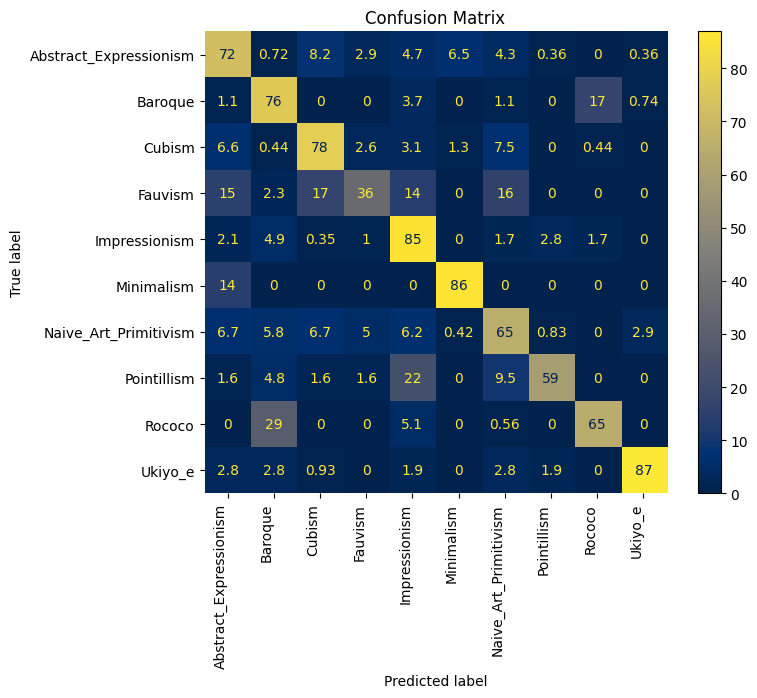

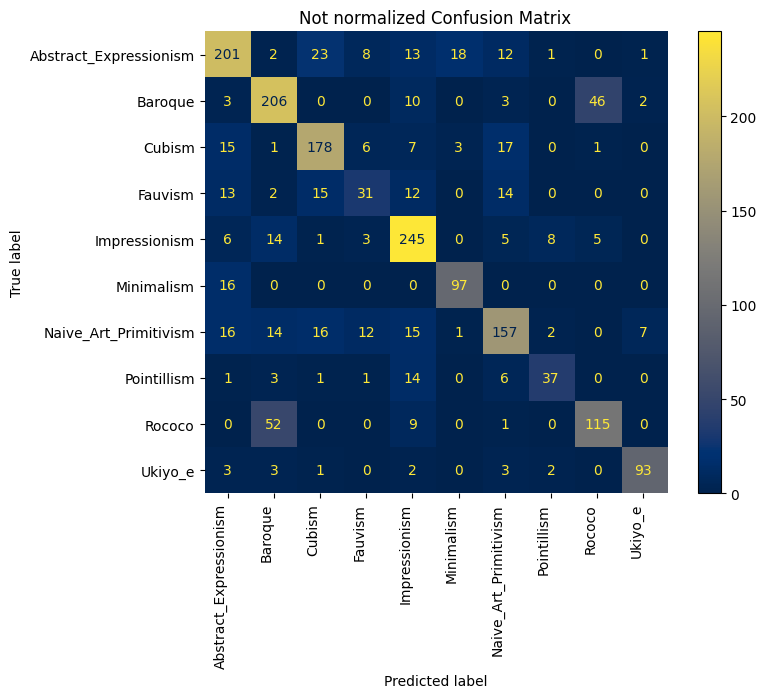

In [ ]:
device = "cpu"
model2 = Efficientnet_b1.load_from_checkpoint(
    checkpoint_path="my/path/efficiennetb1_2-epoch=14-f1_val=0.73.ckpt",
    num_classes=10
)
model2.to(device)

validate_model(modelResS, val_loader)

In [3]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
import torchmetrics
from torchvision import models

f1_efficientnet = []
accuracy_efficientnet = []
recall_efficientnet = []
precision_efficientnet = []

class Efficientnet_b0(pl.LightningModule):
    def __init__(self, num_classes):
        super(Efficientnet_b0, self).__init__()
        self.model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
        self.validation_step_outputs = []
        self.train_step_outputs = []

        for param in self.model.features.parameters():
            param.requires_grad = False

        in_features = self.model.classifier[1].in_features
        self.model.classifier = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes),
            nn.LogSoftmax(dim=1)
        )

        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes, average='weighted')
        self.val_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes, average='weighted')
        self.f1_val = torchmetrics.F1Score(task="multiclass", num_classes=num_classes, average='weighted')
        self.f1_train = torchmetrics.F1Score(task="multiclass", num_classes=num_classes, average='weighted')
        self.precision_val = torchmetrics.Precision(task="multiclass", num_classes=num_classes, average='weighted')
        self.recall_val = torchmetrics.Recall(task="multiclass", num_classes=num_classes, average='weighted')

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = nn.CrossEntropyLoss()(logits, y)
        preds = torch.argmax(logits, dim=1)

        self.accuracy.update(preds, y)
        self.f1_train.update(preds, y)

        self.train_step_outputs.append(loss)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        val_loss = nn.CrossEntropyLoss()(logits, y)
        preds = torch.argmax(logits, dim=1)

        self.val_accuracy.update(preds, y)
        self.f1_val.update(preds, y)
        self.precision_val.update(preds, y)
        self.recall_val.update(preds, y)

        self.validation_step_outputs.append(val_loss)

    def on_train_epoch_end(self):
        train_acc = self.accuracy.compute()
        epoch_f1_train = self.f1_train.compute()
        print(f"Epoch {self.current_epoch}: Train Accuracy: {train_acc:.4f} F1: {epoch_f1_train:.4f}")
        self.accuracy.reset()
        self.f1_train.reset()

    def on_validation_epoch_end(self):
        epoch_val_acc = self.val_accuracy.compute()
        avg_val_loss = torch.stack(self.validation_step_outputs).mean()
        epoch_f1_val = self.f1_val.compute()
        epoch_precision_val = self.precision_val.compute()
        epoch_recall_val = self.recall_val.compute()

        print(f"Epoch {self.current_epoch}: Validation Accuracy: {epoch_val_acc:.4f} F1: {epoch_f1_val:.4f}  Recall: {epoch_recall_val:.4f}  Precision: {epoch_precision_val:.4f}")
        self.log("validation_epoch_accuracy", epoch_val_acc)
        self.log("validation_epoch_loss", avg_val_loss)
        self.log("f1_val", epoch_f1_val)

        f1_efficientnet.append(epoch_f1_val.cpu().numpy())
        accuracy_efficientnet.append(epoch_val_acc.cpu().numpy())
        recall_efficientnet.append(epoch_recall_val.cpu().numpy())
        precision_efficientnet.append(epoch_precision_val.cpu().numpy())

        self.val_accuracy.reset()
        self.f1_val.reset()
        self.precision_val.reset()
        self.recall_val.reset()
        self.validation_step_outputs.clear()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.classifier.parameters(), lr=0.0001)
        return optimizer


In [ ]:
checkpoint_callbackS = ModelCheckpoint(

     monitor='f1_val',
       mode='max',
     dirpath='my/path2/',
     filename='efficiennet_b0_2-{epoch:02d}-{f1_val:.2f}'
)

trainerS = pl.trainer.Trainer(
    max_epochs=25,
   accelerator="cuda",
    callbacks =checkpoint_callbackS,
)

modelResS = Efficientnet_b0(num_classes=10)

trainerS.fit(modelResS, train_loader, test_loader, ckpt_path=None)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 68.2MB/s]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type                | Params | Mode 
--------------------------------------------------------------
0 | model         | EfficientNet        | 4.3 M  | train
1 | accuracy      | MulticlassAccuracy  | 0      | train
2 | val_accuracy  | MulticlassAccuracy  | 0      | train
3 | f1_val        | MulticlassF1Score   | 0      | train
4 | f1_train      | MulticlassF1Score   | 0      | train

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Finished Testing
Testing accuracy: 74.6 %
                        precision    recall  f1-score      support
Abstract_Expressionism   0.788889  0.726962  0.756661   293.000000
Baroque                  0.861111  0.749245  0.801292   331.000000
Cubism                   0.687500  0.758621  0.721311   203.000000
Fauvism                  0.454545  0.625000  0.526316    72.000000
Impressionism            0.780142  0.777385  0.778761   283.000000
Minimalism               0.875000  0.793814  0.832432    97.000000
Naive_Art_Primitivism    0.651261  0.688889  0.669546   225.000000
Pointillism              0.560000  0.756757  0.643678    37.000000
Rococo                   0.686869  0.735135  0.710183   185.000000
Ukiyo_e                  0.921053  0.840000  0.878661   125.000000
accuracy                 0.746083  0.746083  0.746083     0.746083
macro avg                0.726637  0.745181  0.731884  1851.000000
weighted avg             0.758278  0.746083  0.749901  1851.000000
--------------------

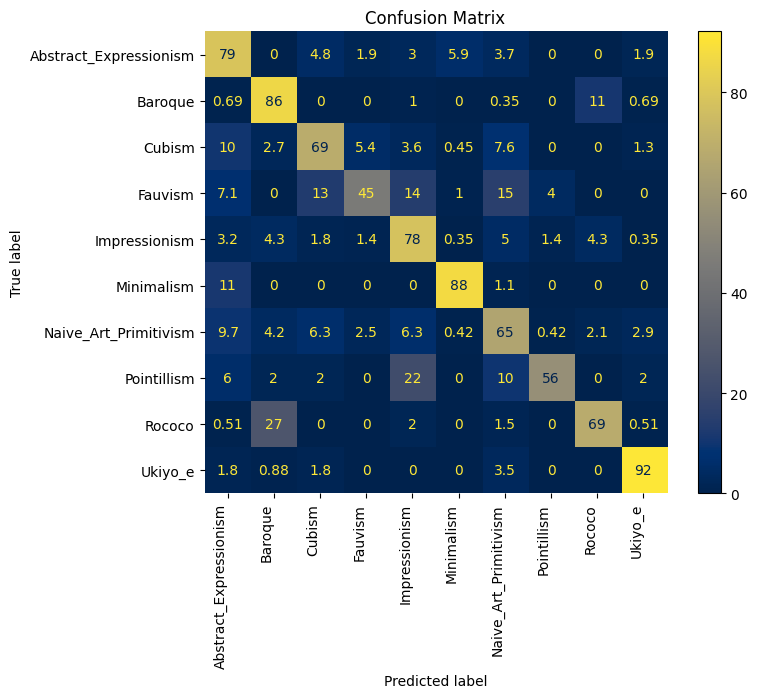

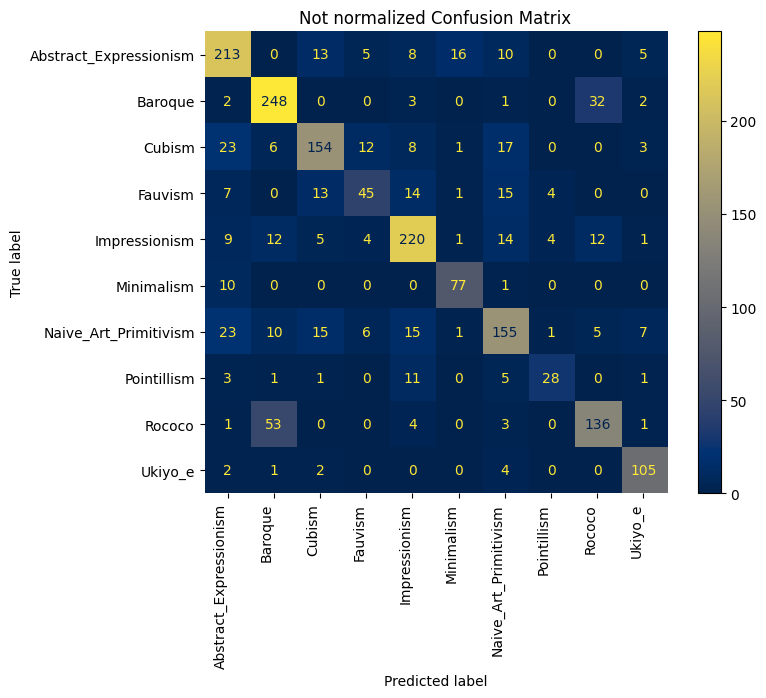

In [ ]:
device = "cpu"
model2 = Efficientnet_b0.load_from_checkpoint(
    checkpoint_path="my/path2/efficiennet_b0_2-epoch=20-f1_val=0.73.ckpt",
    num_classes=10
)
model2.to(device)

validate_model(modelResS, val_loader)